In [1]:
%matplotlib inline
import string
from collections import defaultdict
import itertools
import numpy as np
import pandas as pd
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from nltk.stem.snowball import SnowballStemmer
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from spacy.en import English
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

from helper_functions import transform_tweet

/Users/maksym/virtualenvs/machine_learning/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
class StemmedCountVectorizer(CountVectorizer):
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        def func(doc):
            for w in analyzer(doc):
                stemmed = self.stemmer.stem(w)
                yield stemmed

        return func

In [3]:
def prepare_labels():
    emoji = pd.read_csv('emoji.txt', sep="\n", header=None)
    emoji.columns = ["icons"]
    emoji.index += 1
    return emoji

In [4]:
def transform_labels(emoji):
    for i, name in ((0, 'heart_eyes'), (1, 'yum'), (2, 'sob'), (3, 'blush'), (4, 'weary'),
                    (5, 'smirk'), (6, 'grin'), (7, 'flushed'), (8, 'relaxed'), (9, 'wink')):
        emoji['icons'].replace(name, i, inplace=True)
    emoji.reindex()
    return emoji

In [5]:
def prepare_features():
    tweets = []
    with open('tweets.txt') as f:
        for line in f.readlines():
            tweet = transform_tweet(line)
            tweets.append(tweet)
    return tweets

In [6]:
def classifier(X, y, model_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = cross_validation.StratifiedShuffleSplit(y, test_size=0.2, random_state=30)
    y_pred = y.copy()
    for ii, jj in stratified_k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        #         print y_train.count()
        #         print (y[y == 1].count())
        #         print (y[y == 0].count())
        clf = model_class(**kwargs)
        clf.fit(X_train, y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

In [7]:
emoji = prepare_labels()
print(emoji.icons.unique())
emoji = transform_labels(emoji)
print(emoji.icons.value_counts())

tweets = prepare_features()

inputs_train, inputs_test, \
expected_output_train, expected_output_test = train_test_split(tweets, emoji.as_matrix())  # matched OK

['heart_eyes' 'yum' 'sob' 'blush' 'weary' 'smirk' 'grin' 'flushed'
 'relaxed' 'wink']
2    50525
0    39193
4    26855
3    22894
9    18078
1    16790
5    15231
6    15138
8    10472
7    10155
Name: icons, dtype: int64


In [8]:
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')
text_clf = Pipeline([('vect', stemmed_count_vect),
                     ('tfidf', TfidfTransformer()),
                     # ('mnb', MultinomialNB(fit_prior=False)),
                     ('classifier', RandomForestClassifier()),
#                      ('classifier', LinearSVC()),
                     ])

text_clf.fit(inputs_train, expected_output_train)

# now we can save it to a file
joblib.dump(text_clf, 'model.pkl')

pred_data = text_clf.predict(inputs_test)

# for (sample, pred) in zip(inputs_test, pred_data):
#     print(sample, ">>>>>", pred)

print("Accuracy:", accuracy_score(expected_output_test, pred_data))

/Users/maksym/virtualenvs/machine_learning/lib/python3.6/site-packages/sklearn/pipeline.py:259: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Accuracy: 0.509576979745


In [9]:
print("Confusion: ", confusion_matrix(expected_output_test, pred_data))

Confusion:  [[6690  485 1391  358  460  113   75   29   78  169]
 [ 871 1962  586  153  379   90   44   13   37   89]
 [1422  320 8383  567 1242  239  119   69   76  280]
 [ 953  251 1427 2134  278  234   77   25  102  265]
 [ 827  270 2227  250 2638  115   74   39   38  141]
 [ 360  108  938  257  150 1634   60   10   25  297]
 [ 528  135  831  295  177  141 1430   13   40  211]
 [ 249   42  573  100  122   43   28 1236   12   72]
 [ 448   99  541  236  115   83   40    8  947  112]
 [ 496  109 1115  412  172  312   86   24   55 1652]]


Confusion matrix, without normalization
[[6690  485 1391  358  460  113   75   29   78  169]
 [ 871 1962  586  153  379   90   44   13   37   89]
 [1422  320 8383  567 1242  239  119   69   76  280]
 [ 953  251 1427 2134  278  234   77   25  102  265]
 [ 827  270 2227  250 2638  115   74   39   38  141]
 [ 360  108  938  257  150 1634   60   10   25  297]
 [ 528  135  831  295  177  141 1430   13   40  211]
 [ 249   42  573  100  122   43   28 1236   12   72]
 [ 448   99  541  236  115   83   40    8  947  112]
 [ 496  109 1115  412  172  312   86   24   55 1652]]


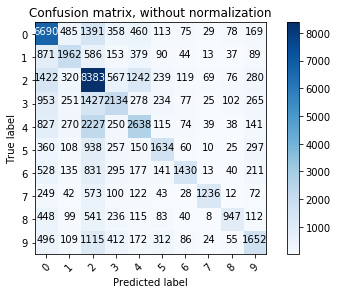

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(expected_output_test, pred_data)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = emoji.icons.unique(),
                      title='Confusion matrix, without normalization')